<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/7_analyze_wave_with_trained_model_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install netcdf4

In [0]:
import numpy as np
import pandas as pd
import os
import re
from scipy import stats
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
def compute_psd(Dataset):
  """takes in netcdf dataset and computes psd, saves as df"""
  
  psd_df = pd.DataFrame(data = Dataset.groupby('slices').sum(dim='times')['__xarray_dataarray_variable__'].values, index = Dataset['slices'].values, columns = Dataset['freq'].values/1000)
  
  return psd_df

In [0]:
#may need to be updated based on file naming scheme
def get_file_info(path, order):
    """takes in a file path for annotation selections table and finds the animal_number and session and saves each accordingly. 
    each file should be named with animal number and exp (e.g. 100_CPA.Table.1.selections)"""
    
    if order == 'animal':
      animal_number, session = re.split('_|-', path.split('/')[-1].split('.')[0])[0:2]
    else:
      session, animal_number = re.split('_|-', path.split('/')[-1].split('.')[0])[0:2] 
    
    print(animal_number, session)
    
    return animal_number, session

In [0]:
netcdf_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
path_names = []
files = os.listdir(netcdf_path)
for file in files: 
  path_names.append(netcdf_path + "/" + file)

len(path_names)
path_names

['/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A2_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A4_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A6_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A8_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A10_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A12_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A2_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A4_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A6_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A8_D3_xr_Dataset.nc',
 '/content/gdrive/

In [0]:
"""takes in path to netcdf file (created using notebook 1), uses compute_spectral_features functions to create a new data set of computed features"""

path = path_names[0]
order = 'animal'
  
animal_number, session = get_file_info(path, order)
print(animal_number, session)

data = xr.open_dataset(path)
print(data['slices'].shape)
    
#compute spectral features
psd_df = compute_psd(data)
    
#create and fill dataframe
psd_df['animal_number'] = [animal_number]*data['slices'].shape[0]
psd_df['session'] = [session]*data['slices'].shape[0]
psd_df['time_stamp'] = data['slices'].values
psd_df = psd_df.dropna(axis = 0)
psd_df = psd_df.iloc[2:,:]

A2 D2
A2 D2
(13333,)


In [0]:
print(psd_df.shape)
psd_df_features = psd_df.iloc[:,:-3]
print(psd_df_features.shape)
psd_df_features.head()

(13331, 260)
(13331, 257)


0.000000    0.488281    0.976562    1.464844    1.953125    2.441406    2.929688    3.417969    3.906250    4.394531    4.882812     5.371094     5.859375     6.347656     6.835938     7.324219     7.812500      8.300781      8.789062      9.277344     9.765625     10.253906    10.742188    11.230469    11.718750    12.207031   12.695312   13.183594   13.671875   14.160156   14.648438   15.136719   15.625000   16.113281   16.601562   17.089844   17.578125   18.066406   18.554688   19.042969   19.531250   20.019531   20.507812   20.996094   21.484375   21.972656   22.460938   22.949219   23.437500   23.925781   24.414062   24.902344   25.390625   25.878906   26.367188   26.855469   27.343750   27.832031   28.320312   28.808594   29.296875   29.785156   30.273438   30.761719   31.250000   31.738281   32.226562   32.714844   33.203125   33.691406   34.179688   34.667969   35.156250   35.644531   36.132812   36.621094   37.109375   37.597656   38.085938   38.574219   39.062500   \
45.0   211.582657  445.518280  458.627411  408.920868  374.327209  457.324402  576.243042  534.702087  365.076935  421.468842  918.288269  1472.423584  1483.596069  1172.490967  1923.170288  5026.049805  9877.003906  13793.490234  14118.834961  10649.110352  5819.315430  2445.262207  1429.106812  1654.310059  1706.902344  1255.959961  822.584045  747.864502  802.745117  676.222473  433.416260  336.485168  423.263672  478.333374  367.680481  216.803665  212.961899  349.075745  448.346710  393.374573  251.699966  181.347794  271.059662  484.079773  710.378418  842.031372  823.767029  674.401978  471.343506  297.436340  188.430283  128.307922   88.826866   62.319679   55.382195   64.984901   74.160919   69.811203   55.353306   42.919250   38.499786   38.508209   37.623184   35.098438   33.358147   33.796238   35.357773   35.822433   33.907623   31.693354   35.498775   51.607880   77.987442  100.913872  103.809502   82.253098   49.513931   25.277744   18.600794   22.573271   24.709820   
67.5    68.427490  109.694138   68.039482   94.756477  226.406754  384.308075  422.237885  289.076447  134.945541  179.918869  432.669769   617.138000   515.509888   403.045532   971.282471  2613.835449  4767.290527   6143.504883   5803.249023   4030.649902  2078.494629  1035.346802   983.779114  1227.154175  1168.443604   831.636841  600.219238  667.258362  864.126465  936.657227  830.321899  676.395081  601.948669  627.894104  708.798767  789.218933  811.956970  732.188477  565.659180  405.119598  354.551941  439.949341  592.727722  714.756531  747.682129  688.691833  568.321838  429.102295  311.566223  237.109329  197.263855  167.595398  136.179947  113.536835  112.631760  126.434944  132.457413  117.354660   90.326797   71.039024   69.080704   77.793770   84.801292   84.445755   80.446220   79.723396   84.965469   92.050285   94.045456   88.402122   80.231400   77.243515   81.057755   85.028870   81.913528   72.570190   65.046791   65.064056   69.431976   70.027382   63.072041   
90.0     4.462072    9.895514   12.183202   14.469267   16.087152   18.137012   23.196445   33.432560   48.475353   64.939049   78.314842    86.089508    89.732727    93.540092   100.653694   109.746223   116.281235    117.677261    116.339996    116.147423   116.600121   113.302956   105.528175   100.492210   106.500298   122.685715  140.194702  155.221451  176.076782  211.752579  254.752579  282.127777  277.279327  247.506561  216.036789  198.700394  193.068604  189.314148  184.316772  181.008591  179.231384  175.391647  171.367996  176.137314  193.519882  211.942383  212.849564  190.131256  157.072861  132.305695  122.012314  118.365913  112.390526  103.352676   95.442192   90.360458   86.855080   85.368126   88.521576   95.959450  101.837044  100.063591   91.155884   81.679535   76.894272   75.972923   75.235054   74.008713   74.820549   78.173477   80.090790   76.842957   70.861572   69.171692   75.040695   82.966240   83.875618   75.000389   62.931683   56.440712   57.612625   
112.5    2.

In [0]:
# center and scale the data for train and test sets
scaler = StandardScaler()
slice_features_scaled = scaler.fit_transform(psd_df_features)

In [0]:
psd_df_features.head()

0.000000    0.488281    0.976562    1.464844    1.953125    2.441406    2.929688    3.417969    3.906250    4.394531    4.882812     5.371094     5.859375     6.347656     6.835938     7.324219     7.812500      8.300781      8.789062      9.277344     9.765625     10.253906    10.742188    11.230469    11.718750    12.207031   12.695312   13.183594   13.671875   14.160156   14.648438   15.136719   15.625000   16.113281   16.601562   17.089844   17.578125   18.066406   18.554688   19.042969   19.531250   20.019531   20.507812   20.996094   21.484375   21.972656   22.460938   22.949219   23.437500   23.925781   24.414062   24.902344   25.390625   25.878906   26.367188   26.855469   27.343750   27.832031   28.320312   28.808594   29.296875   29.785156   30.273438   30.761719   31.250000   31.738281   32.226562   32.714844   33.203125   33.691406   34.179688   34.667969   35.156250   35.644531   36.132812   36.621094   37.109375   37.597656   38.085938   38.574219   39.062500   \
45.0   211.582657  445.518280  458.627411  408.920868  374.327209  457.324402  576.243042  534.702087  365.076935  421.468842  918.288269  1472.423584  1483.596069  1172.490967  1923.170288  5026.049805  9877.003906  13793.490234  14118.834961  10649.110352  5819.315430  2445.262207  1429.106812  1654.310059  1706.902344  1255.959961  822.584045  747.864502  802.745117  676.222473  433.416260  336.485168  423.263672  478.333374  367.680481  216.803665  212.961899  349.075745  448.346710  393.374573  251.699966  181.347794  271.059662  484.079773  710.378418  842.031372  823.767029  674.401978  471.343506  297.436340  188.430283  128.307922   88.826866   62.319679   55.382195   64.984901   74.160919   69.811203   55.353306   42.919250   38.499786   38.508209   37.623184   35.098438   33.358147   33.796238   35.357773   35.822433   33.907623   31.693354   35.498775   51.607880   77.987442  100.913872  103.809502   82.253098   49.513931   25.277744   18.600794   22.573271   24.709820   
67.5    68.427490  109.694138   68.039482   94.756477  226.406754  384.308075  422.237885  289.076447  134.945541  179.918869  432.669769   617.138000   515.509888   403.045532   971.282471  2613.835449  4767.290527   6143.504883   5803.249023   4030.649902  2078.494629  1035.346802   983.779114  1227.154175  1168.443604   831.636841  600.219238  667.258362  864.126465  936.657227  830.321899  676.395081  601.948669  627.894104  708.798767  789.218933  811.956970  732.188477  565.659180  405.119598  354.551941  439.949341  592.727722  714.756531  747.682129  688.691833  568.321838  429.102295  311.566223  237.109329  197.263855  167.595398  136.179947  113.536835  112.631760  126.434944  132.457413  117.354660   90.326797   71.039024   69.080704   77.793770   84.801292   84.445755   80.446220   79.723396   84.965469   92.050285   94.045456   88.402122   80.231400   77.243515   81.057755   85.028870   81.913528   72.570190   65.046791   65.064056   69.431976   70.027382   63.072041   
90.0     4.462072    9.895514   12.183202   14.469267   16.087152   18.137012   23.196445   33.432560   48.475353   64.939049   78.314842    86.089508    89.732727    93.540092   100.653694   109.746223   116.281235    117.677261    116.339996    116.147423   116.600121   113.302956   105.528175   100.492210   106.500298   122.685715  140.194702  155.221451  176.076782  211.752579  254.752579  282.127777  277.279327  247.506561  216.036789  198.700394  193.068604  189.314148  184.316772  181.008591  179.231384  175.391647  171.367996  176.137314  193.519882  211.942383  212.849564  190.131256  157.072861  132.305695  122.012314  118.365913  112.390526  103.352676   95.442192   90.360458   86.855080   85.368126   88.521576   95.959450  101.837044  100.063591   91.155884   81.679535   76.894272   75.972923   75.235054   74.008713   74.820549   78.173477   80.090790   76.842957   70.861572   69.171692   75.040695   82.966240   83.875618   75.000389   62.931683   56.440712   57.612625   
112.5    2.

In [0]:
#load saved model
pkl_filename = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/pickled_models/trained_pickle_model_painandCPA_PSD_100noise_svmstrat_noupsample.pkl'
trained_model = pickle.load(open(pkl_filename, 'rb'))
trained_model

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
#use model to classify slices based on features
pred = trained_model.predict(slice_features_scaled)
pred_prob = trained_model.predict_proba(slice_features_scaled)
psd_df['pred'] = pred
psd_df['pred_proba'] = pred_prob[:,1]
print(pred[pred == 1].shape)
print(pred_prob[pred_prob > .65].shape)
print(pred_prob[pred_prob == 1].shape)
psd_df.head()

(252,)
(13274,)
(0,)


0.0  0.48828125   0.9765625  1.46484375    1.953125  2.44140625   2.9296875  3.41796875     3.90625  4.39453125   4.8828125   5.37109375     5.859375   6.34765625    6.8359375   7.32421875       7.8125    8.30078125     8.7890625    9.27734375     9.765625  10.25390625   10.7421875  11.23046875     11.71875  12.20703125  12.6953125  13.18359375   13.671875  14.16015625  14.6484375  15.13671875      15.625  16.11328125  16.6015625  17.08984375   17.578125  18.06640625  18.5546875  19.04296875    19.53125  20.01953125  20.5078125  20.99609375   21.484375  21.97265625  22.4609375  22.94921875     23.4375  23.92578125  24.4140625  24.90234375   25.390625  25.87890625  26.3671875  26.85546875    27.34375  27.83203125  28.3203125  28.80859375   29.296875  29.78515625  30.2734375  30.76171875      31.25  31.73828125  32.2265625  32.71484375  33.203125  33.69140625  34.1796875  34.66796875   35.15625  35.64453125  36.1328125  36.62109375   37.109375  37.59765625  38.0859375  \
45.0   211.582657  445.518280  458.627411  408.920868  374.327209  457.324402  576.243042  534.702087  365.076935  421.468842  918.288269  1472.423584  1483.596069  1172.490967  1923.170288  5026.049805  9877.003906  13793.490234  14118.834961  10649.110352  5819.315430  2445.262207  1429.106812  1654.310059  1706.902344  1255.959961  822.584045   747.864502  802.745117   676.222473  433.416260   336.485168  423.263672   478.333374  367.680481   216.803665  212.961899   349.075745  448.346710   393.374573  251.699966   181.347794  271.059662   484.079773  710.378418   842.031372  823.767029   674.401978  471.343506   297.436340  188.430283   128.307922   88.826866    62.319679   55.382195    64.984901   74.160919    69.811203   55.353306    42.919250   38.499786    38.508209   37.623184    35.098438  33.358147    33.796238   35.357773    35.822433  33.907623    31.693354   35.498775    51.607880  77.987442   100.913872  103.809502    82.253098   49.513931    25.277744   18.600794   
67.5    68.427490  109.694138   68.039482   94.756477  226.406754  384.308075  422.237885  289.076447  134.945541  179.918869  432.669769   617.138000   515.509888   403.045532   971.282471  2613.835449  4767.290527   6143.504883   5803.249023   4030.649902  2078.494629  1035.346802   983.779114  1227.154175  1168.443604   831.636841  600.219238   667.258362  864.126465   936.657227  830.321899   676.395081  601.948669   627.894104  708.798767   789.218933  811.956970   732.188477  565.659180   405.119598  354.551941   439.949341  592.727722   714.756531  747.682129   688.691833  568.321838   429.102295  311.566223   237.109329  197.263855   167.595398  136.179947   113.536835  112.631760   126.434944  132.457413   117.354660   90.326797    71.039024   69.080704    77.793770   84.801292    84.445755  80.446220    79.723396   84.965469    92.050285  94.045456    88.402122   80.231400    77.243515  81.057755    85.028870   81.913528    72.570190   65.046791    65.064056   69.431976   
90.0     4.462072    9.895514   12.183202   14.469267   16.087152   18.137012   23.196445   33.432560   48.475353   64.939049   78.314842    86.089508    89.732727    93.540092   100.653694   109.746223   116.281235    117.677261    116.339996    116.147423   116.600121   113.302956   105.528175   100.492210   106.500298   122.685715  140.194702   155.221451  176.076782   211.752579  254.752579   282.127777  277.279327   247.506561  216.036789   198.700394  193.068604   189.314148  184.316772   181.008591  179.231384   175.391647  171.367996   176.137314  193.519882   211.942383  212.849564   190.131256  157.072861   132.305695  122.012314   118.365913  112.390526   103.352676   95.442192    90.360458   86.855080    85.368126   88.521576    95.959450  101.837044   100.063591   91.155884    81.679535  76.894272    75.972923   75.235054    74.008713  74.820549    78.173477   80.090790    76.842957  70.861572    69.171692   75.040695    82.966240   83.875618    75.000389   62.931683   
112.5    2.883132    7

In [0]:
pred_prob[:,1]

array([0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3])

(array([12263.,   890.,    68.,    39.,    21.,    12.,     4.,     8.,
            9.,    17.]),
 array([0.00038219, 0.10034397, 0.20030575, 0.30026753, 0.40022931,
        0.50019109, 0.60015287, 0.70011465, 0.80007643, 0.90003821,
        0.99999999]),
 <a list of 10 Patch objects>)

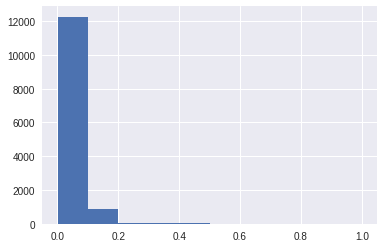

In [0]:
plt.hist(pred_prob[:,1])

In [0]:
pred_prob.mean()

0.4999999999999999

In [0]:
#use model to classify slices based on features
pred = trained_model.predict(slice_features_scaled)
psd_df['pred'] = pred
print(pred[pred == 1].shape)
psd_df.head()

(13257,)


0.0  0.48828125   0.9765625  1.46484375    1.953125  2.44140625   2.9296875  3.41796875     3.90625  4.39453125   4.8828125   5.37109375     5.859375   6.34765625    6.8359375   7.32421875       7.8125    8.30078125     8.7890625    9.27734375     9.765625  10.25390625   10.7421875  11.23046875     11.71875  12.20703125  12.6953125  13.18359375   13.671875  14.16015625  14.6484375  15.13671875      15.625  16.11328125  16.6015625  17.08984375   17.578125  18.06640625  18.5546875  19.04296875    19.53125  20.01953125  20.5078125  20.99609375   21.484375  21.97265625  22.4609375  22.94921875     23.4375  23.92578125  24.4140625  24.90234375   25.390625  25.87890625  26.3671875  26.85546875    27.34375  27.83203125  28.3203125  28.80859375   29.296875  29.78515625  30.2734375  30.76171875      31.25  31.73828125  32.2265625  32.71484375  33.203125  33.69140625  34.1796875  34.66796875   35.15625  35.64453125  36.1328125  36.62109375  37.109375  37.59765625  38.0859375  \
0.0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000   
22.5    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000   
45.0  211.582657  445.518280  458.627411  408.920868  374.327209  457.324402  576.243042  534.702087  365.076935  421.468842  918.288269  1472.423584  1483.596069  1172.490967  1923.170288  5026.049805  9877.003906  13793.490234  14118.834961  10649.110352  5819.315430  2445.262207  1429.106812  1654.310059  1706.902344  1255.959961  822.584045   747.864502  802.745117   676.222473  433.416260   336.485168  423.263672   478.333374  367.680481   216.803665  212.961899   349.075745  448.346710   393.374573  251.699966   181.347794  271.059662   484.079773  710.378418   842.031372  823.767029   674.401978  471.343506   297.436340  188.430283   128.307922   88.826866    62.319679   55.382195    64.984901   74.160919    69.811203   55.353306    42.919250   38.499786    38.508209   37.623184    35.098438  33.358147    33.796238   35.357773    35.822433  33.907623    31.693354   35.498775    51.607880  77.987442   100.913872  103.809502    82.253098  49.513931    25.277744   18.600794   
67.5   68.427490  109.694138 

In [0]:
psd_df[psd_df['pred'] == 1]

0.0    0.48828125     0.9765625    1.46484375      1.953125    2.44140625     2.9296875    3.41796875       3.90625    4.39453125     4.8828125    5.37109375       5.859375     6.34765625      6.8359375     7.32421875         7.8125     8.30078125      8.7890625    9.27734375      9.765625   10.25390625     10.7421875    11.23046875       11.71875    12.20703125    12.6953125   13.18359375     13.671875   14.16015625    14.6484375   15.13671875        15.625   16.11328125    16.6015625   17.08984375      17.578125    18.06640625     18.5546875    19.04296875       19.53125    20.01953125     20.5078125    20.99609375      21.484375    21.97265625     22.4609375    22.94921875        23.4375    23.92578125     24.4140625    24.90234375      25.390625    25.87890625     26.3671875    26.85546875       27.34375    27.83203125     28.3203125    28.80859375      29.296875    29.78515625     30.2734375    30.76171875          31.25    31.73828125     32.2265625  \
765.0     22787.498047  43195.914062  38079.355469  35810.046875  41698.171875  53818.761719  62185.984375  59671.910156  52666.343750  55143.507812  72434.804688  99860.210938  142031.250000  222978.421875  362244.937500  541937.562500  713912.125000  847378.562500  955064.875000  1.056451e+06  1.125891e+06  1.107180e+06  991757.500000  861676.187500  830932.687500  948034.500000  1.173378e+06  1.442959e+06  1.717400e+06  1.953293e+06  2.065524e+06  1.974623e+06  1.703566e+06  1.389905e+06  1.169406e+06  1.057237e+06  966970.000000  836564.812500  699714.750000  622413.875000  602863.937500  569948.375000  474989.468750  351947.218750  274012.562500  270999.812500  308322.812500  336360.718750  337092.531250  320674.562500  298344.687500  274183.312500  254190.546875  245667.421875  245274.437500  239714.203125  225011.250000  218170.375000  240469.828125  289564.250000  334978.875000  344387.156250  312011.781250  259897.093750  214535.609375  185503.953125  165101.531250   
787.5      6752.374512  12124.376953   8847.359375   6169.977051   6716.877930  10251.906250  13414.578125  14692.709961  18570.353516  30883.841797  49871.425781  68288.851562   90221.953125  141063.421875  247124.109375  396667.375000  527612.187500  568934.000000  503050.218750  3.849738e+05  2.953359e+05  2.750507e+05  306556.250000  351360.750000  394315.875000  448987.375000  5.304349e+05  6.330919e+05  7.326213e+05  7.991824e+05  8.072473e+05  7.442792e+05  6.224016e+05  4.816050e+05  3.708587e+05  3.164643e+05  306190.593750  304748.437500  284499.187500  242466.078125  193088.484375  150759.203125  120296.203125   99314.953125   84495.367188   74493.359375   68964.656250   66632.906250   64626.507812   59714.203125   50686.066406   39863.109375   31916.732422   30545.457031   35786.980469   44134.050781   50929.082031   52879.367188   49252.496094   41724.140625   33318.402344   26798.035156   23193.240234   21508.406250   19974.501953   17782.341797   15645.546875   
810.0      3332.316406   6537.310059   5813.416992   4524.512207   4014.152100   5274.466797   7143.450684   8203.215820  10361.566406  18038.185547  32659.644531  50436.703125   68553.929688   92420.718750  131929.046875  187129.468750  239247.968750  260659.796875  237524.218750  1.837370e+05  1.320825e+05  1.099931e+05  120742.421875  144724.031250  158087.437500  152996.656250  1.435635e+05  1.527154e+05  1.903371e+05  2.412431e+05  2.746056e+05  2.677873e+05  2.236602e+05  1.661963e+05  1.198640e+05  9.287965e+04   77944.437500   65208.988281   52000.984375   41357.863281   35073.355469   30854.707031   25607.320312   19234.464844   14220.690430   12342.786133   12797.510742   13391.435547   12743.654297   11045.005859    9171.807617    7614.465820    6285.135742    4993.906250    3814.984619    2976.164062    2542.925537    2333.773926    2146.377441    1978.905273    1964.087891    2125.490479    2294.972412    2297.449219    2144.626709    1984.417603    1896.903198   
1822.5       28.505527     61.484512     67.291031 

In [0]:
#viz predicted calls (need path for corresponding netcdf files)
#netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'

dim = np.int(np.ceil(np.sqrt(slice_features_df.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))

data = xr.open_dataset(path_names[0])

for index, row in slice_features_df.iterrows():
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

KeyboardInterrupt: ignored

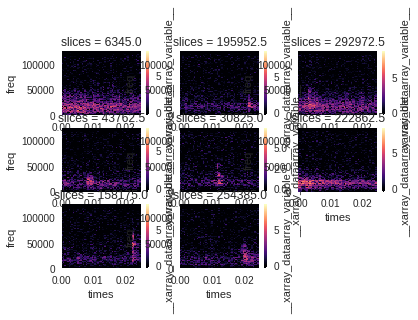

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1